In [1]:
import numpy as np
import string
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
df.shape

(20972, 9)

In [6]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

### data manipulation

In [7]:
# count the number of documents per category 
for c in df[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]:
    print(c + " " + str(df[c].sum()))

Computer Science 8594
Physics 6013
Mathematics 5618
Statistics 5206
Quantitative Biology 587
Quantitative Finance 249


In [8]:
# select observations from the three most common topics
df2 = df[(df["Computer Science"] == 1) | (df["Physics"] == 1) | (df["Mathematics"] == 1)]

In [9]:
df2.shape

(18551, 9)

In [10]:
# drop unwanted variables 
df2.drop(['ID', 'Statistics', 'Quantitative Biology', 'Quantitative Finance'], axis=1, inplace=True)

In [11]:
df2.head(1)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0


In [12]:
df2['sum'] = df2[['Computer Science', 'Physics', 'Mathematics']].agg('sum', axis=1)

In [13]:
# there are 1655 documents included in more than one category
df2['sum'].value_counts()

1    16896
2     1636
3       19
Name: sum, dtype: int64

In [14]:
# delete docs included in more than one category
df2 = df2.drop(df2[df2['sum'] != 1].index)

In [15]:
df2.shape

(16896, 6)

In [16]:
y = df2.drop(['TITLE', 'ABSTRACT', 'sum'], axis=1)

In [17]:
y.shape

(16896, 3)

In [18]:
y.head(1)

,Computer Science,Physics,Mathematics
0,1,0,0


In [19]:
# final number of documents per category
for c in y[['Computer Science', 'Physics', 'Mathematics']]:
    print(c + " " + str(y[c].sum()))

Computer Science 7241
Physics 5219
Mathematics 4436


### Document preprocessing

In [20]:
df2['doc'] = df2.TITLE + df2.ABSTRACT

In [21]:
df2.drop(df2.columns.difference(['doc']), 1, inplace=True)

In [22]:
df2.head(1)

,doc
0,Reconstructing Subject-Specific Effect Maps P...


In [23]:
df2.doc[8]

'SPH calculations of Mars-scale collisions: the role of the Equation of State, material rheologies, and numerical effects  We model large-scale ($\\approx$2000km) impacts on a Mars-like planet using a\nSmoothed Particle Hydrodynamics code. The effects of material strength and of\nusing different Equations of State on the post-impact material and temperature\ndistributions are investigated. The properties of the ejected material in terms\nof escaping and disc mass are analysed as well. We also study potential\nnumerical effects in the context of density discontinuities and rigid body\nrotation. We find that in the large-scale collision regime considered here\n(with impact velocities of 4km/s), the effect of material strength is\nsubstantial for the post-impact distribution of the temperature and the\nimpactor material, while the influence of the Equation of State is more subtle\nand present only at very high temperatures.\n'

In [24]:
stopwords = nltk.corpus.stopwords.words('english')
# Load lemmatizer
lemmatizer = WordNetLemmatizer()
# Load stemmer
#stemmer = SnowballStemmer("english")

In [25]:
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # convert all words to lowercase
    tokens = [tokens.lower() for tokens in tokens]
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    # lemmatizer
    tokens=[lemmatizer.lemmatize(word, pos='v') for word in tokens]
    # stemming
#    stems = [stemmer.stem(t) for t in tokens]
#    tokens = ' '.join(tokens)
    return tokens

In [26]:
df2['doc'] = df2['doc'].apply(clean_doc)

### Gensim

In [27]:
tokenized_docs = df2["doc"].to_numpy()

In [28]:
# train Word2Vec model based on tokenized documents. The sentence parameter expects list of lists.
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=4, seed=42)

In [29]:
# validate results by checking the similarity of relevant words. 
model.wv.most_similar("computer")

[('vision', 0.9202690720558167),
 ('modern', 0.9132802486419678),
 ('robotics', 0.8576211929321289),
 ('neuroscience', 0.8483121991157532),
 ('ai', 0.846819281578064),
 ('industrial', 0.841512143611908),
 ('intelligence', 0.8331251740455627),
 ('science', 0.8291126489639282),
 ('scientific', 0.8141380548477173),
 ('genetics', 0.8124673962593079)]

### Create Document Vectors from Word Embedding

In [30]:
# Vectorize function, generates a feature vector per document using the average of the word vectors.
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [31]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(16896, 100)

### Elbow method

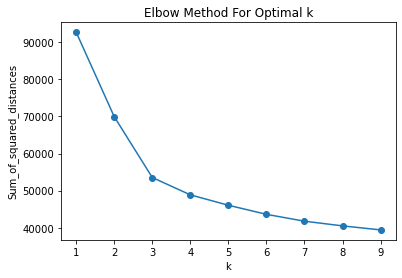

In [32]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(vectorized_docs)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### MiniBatchKMeans

In [33]:
km = MiniBatchKMeans(n_clusters=3, batch_size=100).fit(vectorized_docs)
print(f"For n_clusters = {3}")
print(f"Silhouette coefficient: {silhouette_score(vectorized_docs, km.labels_):0.2f}")
print(f"Inertia:{km.inertia_}")

For n_clusters = 3
Silhouette coefficient: 0.27
Inertia:53613.00918652651


In [34]:
# compute the Silhouette Coefficient for each sample
sample_silhouette_values = silhouette_samples(vectorized_docs, km.labels_)

In [35]:
# create a dataframe to visualize the results
ab = np.zeros((3,5))
df_results = pd.DataFrame(ab, columns = ['Cluster_n', 'Size', 'Avg', 'Min', 'Max'])
df_results = df_results.astype({'Cluster_n': 'int64', 'Size': 'int64'})

In [36]:
## size of the clusters, average, min and max Silhouette Coefficient per cluster
for i in range(3):
    cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
    
    df_results.iloc[i, 0] = i
    df_results.iloc[i, 1] = cluster_silhouette_values.shape[0]
    df_results.iloc[i, 2] = cluster_silhouette_values.mean(),
    df_results.iloc[i, 3] = cluster_silhouette_values.min(),
    df_results.iloc[i, 4] = cluster_silhouette_values.max()
    
print(df_results.head())

   Cluster_n  Size       Avg       Min       Max
0          0  4407  0.237130 -0.069884  0.451846
1          1  7792  0.269476 -0.020113  0.456283
2          2  4697  0.314471  0.004777  0.504091


In [37]:
df_clusters = pd.DataFrame({
    "text": df2['doc'],
    "cluster": km.labels_
})

In [38]:
df_clusters.head(4)

,text,cluster
0,"[reconstruct, subjectspecific, effect, map, pr...",1
1,"[rotation, invariance, neural, network, rotati...",1
2,"[spherical, polyharmonics, poisson, kernels, p...",0
3,"[finite, element, approximation, stochastic, m...",0


In [39]:
df_clusters['cluster'].value_counts()

1    7792
2    4697
0    4407
Name: cluster, dtype: int64

### Quality review of clusters

In [50]:
# the word vectors closest to the clusters' centroids are the most representative terms per cluster.
print("Most representative terms per cluster:")
for i in range(3):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[km.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster:
Cluster 0: extremal boundedness admissible congruences positivity equality eulers isoperimetric morse monomial 
Cluster 1: advise naïve goaloriented elicitation imputation kernelbased preferencebased divideandconquer extensibility grouplevel 
Cluster 2: hydrostatic photoinduced fluctuate isotope hadronic cw finitesize magnetostriction unphysical bagnold 


In [40]:
# the document vectors closest to the clusters' centroids are the most representative docs per cluster.
test_cluster = 0
print("Most representative documents per cluster:")
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - km.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:3]:
    print(tokenized_docs[d])
    print("-------------")

Most representative documents per cluster:
['local', 'formulas', 'ehrhart', 'coefficients', 'lattice', 'tile', 'show', 'mcmullen', 'coefficients', 'ehrhart', 'polynomial', 'lattice', 'polytope', 'write', 'weight', 'sum', 'facial', 'volumes', 'weight', 'local', 'formula', 'depend', 'outer', 'normal', 'con', 'face', 'far', 'unique', 'paper', 'develop', 'infinite', 'class', 'local', 'formulas', 'base', 'choices', 'fundamental', 'domains', 'sublattices', 'obtain', 'polyhedral', 'volume', 'computations', 'hereby', 'also', 'give', 'kind', 'geometric', 'interpretation', 'ehrhart', 'coefficients', 'since', 'construction', 'give', 'us', 'great', 'variety', 'possible', 'local', 'formulas', 'instance', 'choose', 'fit', 'well', 'give', 'polyhedral', 'symmetry', 'group', 'contrast', 'constructions', 'local', 'formulas', 'rely', 'triangulations', 'rational', 'con', 'simplicial', 'even', 'unimodular', 'ones']
-------------
['gamma', 'factor', 'intertwine', 'periods', 'distinction', 'inner', 'form', '

### Check predictions

In [41]:
# create new categorical variable from binary variables.
y['cluster'] = y[['Computer Science', 'Physics', 'Mathematics']].idxmax(axis=1)

In [42]:
# map cluster labels, the numbers' equivalences have been inferred from the results of the most representative terms and docs. 
y['cluster'].replace({'Computer Science': 1, 'Physics': 2, 'Mathematics': 0}, inplace=True)

Text(0.5, 1.0, 'Confusion Matrix')

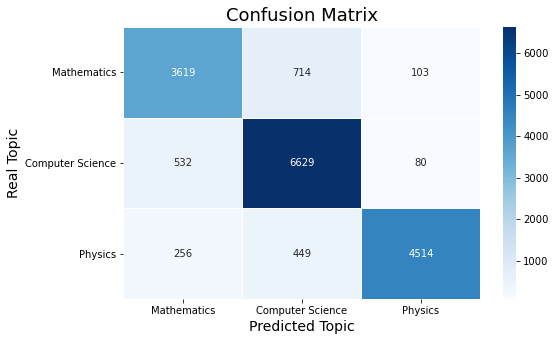

In [48]:
# confusion matrix
cf_matrix=confusion_matrix(y['cluster'], df_clusters['cluster'])

fig, ax = plt.subplots(figsize=(8,5)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g', xticklabels=['Mathematics', 'Computer Science', 'Physics'], 
            yticklabels=['Mathematics', 'Computer Science', 'Physics'], cmap="Blues")
ax.set_xlabel("Predicted Topic", fontsize=14)
ax.set_ylabel("Real Topic", fontsize=14)
ax.set_title("Confusion Matrix", fontsize=18)

In [46]:
print(classification_report(y['cluster'], df_clusters['cluster']))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4436
           1       0.85      0.92      0.88      7241
           2       0.96      0.86      0.91      5219

    accuracy                           0.87     16896
   macro avg       0.88      0.87      0.87     16896
weighted avg       0.88      0.87      0.87     16896

